# VISST data viewer

This code views data from VISST netcdf files created by Patrick Minnis. 

In [174]:
# Load required libraries
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import datetime
import math
import glob
%matplotlib inline

In [175]:
year = 2006
day = 1
month = 1
hour = 4
minute = 0
second = 0
year_str = "%04d" % year
day_str = "%02d" % day
month_str = "%02d" % month

data_path = '/home/rjackson/data/visst/'

print('Looking for files with format' + data_path + 'twpvisstgrid*' +  year_str + month_str + day_str + '*.cdf')
data_list = glob.glob(data_path + 'twpvisstgrid*' +  year_str + month_str + day_str + '*.cdf')

data_list

Looking for files with format/home/rjackson/data/visst/twpvisstgrid*20060101*.cdf


['/home/rjackson/data/visst/twpvisstgridm1rv1minnisX30.c1.20060101.003300.custom.cdf']

# NetCDF parameters in VISST file:

latitude = latitude of pixel<br />
longtiude = longtidue of pixel<br />
time = time in seconds after midnight<br />
cloud_percentage = Cloud percentage<br />
optical_depth_linear = Linear average of optical depth<br />
optical_depth_log = Log average of optical depth<br />
optical_depth_linear_sd = Linear standard deviation of optical depth<br />
optical_depth_log_sd = Log standard deviation of optical depth<br />
ir_emit = IR emissivity average<br />
it_emit_sd = IR emissiviey standard deviation<br />
particle_size = Average particle size<br />
particle_size_sd = Particle size standard deviation<br />
water_path = Water path average<br />
water_path_sd = Water path standard deviation<br />
cloud_height_top = Cloud height top average<br />
cloud_height_top_sd = Cloud height top standard deviation<br />
cloud_height_base = Cloud base height average<br />
cloud_height_base_sd = Cloud base height sd<br />
cloud_pressure_top_sd = Cloud pressure top standard deviation<br />
cloud_pressure_center_average = Cloud pressure center average<br />
cloud_pressure_center_sd = Cloud pressure center std dev.<br />
cloud_pressure_base = Cloud base pressure<br />
ir_temperature = Infrared temperature average<br />
broadband_shortwave_albedo = Broadband shortwave albedo average<br />
broadband_longwave_flux = Broadband longwave flux<br />
surface_net_shortwave_flux = Surface net shortwave flux average<br />
surface_net_longwave_flux = Surface net longwave flux average<br />
surface_down_shortwave_flux = Shortwave downward flux average<br />
surface_down_longwave_flux = Longwave downward flux average<br />

clearsky_ir_temperature = long_name: Infrared clear sky temperature average<br />  
clearsky_vis_reflectance = Visible clear sky reflectance average<br />
cloud_temperature = Cloud temperature average<br />
cloud_temperature_sd = Cloud temperature standard deviation<br />
visible_reflectance = Visible reflectance average<br />
cloud_percentage_level = Cloud percentage at 3 levels<br />
cloud_temperature_top_level = Cloud temperature top average at 3 levels<br />
cloud_temperature_center_level = Cloud temperature center average at 3 levels<br />
cloud_temperature_base_level = Cloud temperature base average at 3 levels<br />
cloud_pressure_top_level = Cloud pressure top average at 3 levels<br />
cloud_pressure_center_level = Cloud pressure center average at 3 levels<br />
cloud_pressure_base_level = Cloud pressure base average at 3 levels<br />
optical_depth_linear_level = Optical depth linear average at 3 levels<br />
optical_depth_log_level = Optical depth log average at 3 levels<br />
cloud_height_top_level = Cloud height top average at 3 levels<br />
cloud_height_center_level = Cloud height center average at 3 levels<br />
cloud_height_base_level = Cloud height base average at 3 levels<br />
                  
The data frequency is once an hour. Since different satellites were used from 2003 to 2014 in the VISST database,<br /> different parameters at different sampling frequencies may be available. <br />

Dimensions for 3D variables are time by lat by lon by (level or cloud type)


In [176]:
cdf_data = Dataset(data_list[0], mode='r')

# Load lat, lon, and time parameters
Latitude = cdf_data.variables['latitude']
Longitude = cdf_data.variables['longitude']
Time = cdf_data.variables['time']

# Put lat and lon into 2D grid
Lon, Lat = np.meshgrid(Longitude, Latitude)

# Load brightness temperature
IRBrightness = cdf_data.variables['ir_temperature']



Since time is in seconds after midnight, we need to use datetime to convert it to HH:MM:SS for the plot

In [177]:
# Find the index in the file that is closest to the timestamp you specify
def find_closest_timestep_index(scan_hour, scan_minute, scan_second=0):
   
   time_stamp = datetime.datetime(year, 
                                  month,
                                  day,
                                  scan_hour, 
                                  scan_minute, 
                                  scan_second)
   
   indicies = np.arange(1, len(Time))
   

   # Set the initial value for minimum difference between scan time and input time to be unrealistically large (> 1 day)
   min_delta_time = datetime.timedelta(40)
   
   for i in indicies:
       hours = math.floor(Time[i]/3600)
       minutes = math.floor((Time[i] - hours*3600)/60)
       seconds = Time[i] - hours*3600 - minutes*60;
       temp = datetime.datetime(year,
                                month,
                                day,
                                int(hours), 
                                int(minutes),
                                int(seconds))
       delta_time = abs(temp - time_stamp)
       if(delta_time < min_delta_time):
            min_delta_time = delta_time
            lowest_index = i
     
   return lowest_index   

# Convert seconds to midnight to a string format
def seconds_to_midnight_to_string(time_secs_after_midnight):
     
    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    temp = datetime.time(int(hours), int(minutes), )
    return temp.strftime('%H:%M:%S')   

def dms_to_decimal(deg, minutes, seconds):
    return deg+minutes/60+seconds/3600


In [178]:
IRBrightness

<class 'netCDF4._netCDF4.Variable'>
int32 ir_temperature(time, lat, lon, scn_type)
    long_name: Infrared temperature average
    units: K
    scale_factor: 0.01
    valid_min: 160.0
    valid_max: 340.0
unlimited dimensions: time
current shape = (24, 34, 22, 2)
filling off

Plot the satellite image over Darwin. Right now, the grid is centered in a 500 km by 500 km over the TWP site in Darwin.

TWP Darwin Location: 12° 25' 28.56" S, 130° 53' 29.75" E

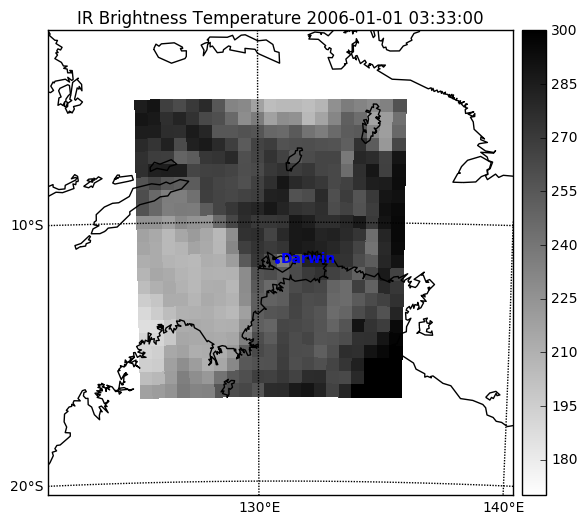

In [189]:
# Set up projection
Darwin_Lat = dms_to_decimal(-12,25,28.56)
Darwin_Lon = dms_to_decimal(130,53,29.75)
m = Basemap(width=2000000, height=2000000,
            resolution='l', projection='stere', \
            lat_0=Darwin_Lat,
            lon_0=Darwin_Lon)

xi, yi = m(Lon, Lat)
darwin_x, darwin_y = m(Darwin_Lon, Darwin_Lat)

# Plot data
figure = plt.figure(figsize=(8,6))
index = find_closest_timestep_index(hour, minute, second)
data = np.squeeze(IRBrightness[index,:,:,0])

colors = m.pcolor(xi, yi, data, cmap='gray_r', vmin=170, vmax=300)
plt.text(darwin_x, darwin_y, 'Darwin', fontweight='bold', color='blue')
plt.plot(darwin_x*0.985, darwin_y*1.01, 'b.')

m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)
m.drawcoastlines()
m.drawcountries()
m.colorbar()

plt.title('IR Brightness Temperature ' 
        + year_str 
        + '-' 
        + month_str 
        + '-'
        + day_str 
        + ' '
        + seconds_to_midnight_to_string(Time[index]))